### Calibration for Classification

In [1]:
from sklearn.datasets import make_classification, make_biclusters, make_moons
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import pandas as pd

%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

In [2]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

### Divide data into train, calibration, and test

It should be noted that if the `n_samples` is small, all methods perform poorly.

In [3]:
X, y = make_moons(n_samples=5000)

X_train_cal, X_test, y_train_cal, y_test = train_test_split(X, y, test_size=.4, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train_cal, y_train_cal, test_size=0.4, random_state=42)


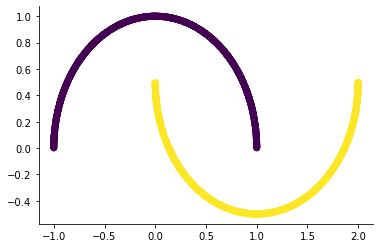

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
#plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='Test', alpha=0.2)
#plt.scatter(X_cal[:, 0], X_cal[:, 1], c=y_cal, label='Cal', alpha=0.5)



sns.despine()


### Fit the classification model to the training dataset

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
lr = LogisticRegression(C=0.1)

In [7]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [8]:
lr.coef_

array([[ 1.08535991, -3.7870853 ]])

In [9]:
lr.intercept_

array([0.42515354])

In [10]:
lr.predict_proba(X_test)[:, 1]

array([0.82244314, 0.11114273, 0.32905312, ..., 0.87316967, 0.794603  ,
       0.55168098])

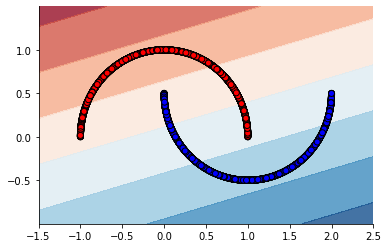

In [11]:
DecisionBoundaryDisplay.from_estimator(
    lr, X, cmap=cm, alpha=0.8, eps=0.5, grid_resolution=400
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")
sns.despine()

In [12]:
y_true = y_test
y_pred = lr.predict(X_test)

In [13]:
y_conf = lr.predict_proba(X_test)[:, 1]

In [14]:
# Put reliability_diagrams.py from https://github.com/hollance/reliability-diagrams in this folder
from reliability_diagrams import *

In [15]:
nbins = 10

res = {}
res["Uncalibrated"] = compute_calibration(y_true, y_pred, y_conf, num_bins=nbins)
res["Uncalibrated"]["brier"] = brier_score_loss(y_true, y_conf)

In [16]:
y_conf.mean()

0.5040043171214

In [17]:
(y_pred == y_true).mean()

0.8795

In [18]:
y_conf[y_conf < 0.3].mean(), res["Uncalibrated"]["confidences"][1]

(0.09908032168064464, 0.14249820577591474)

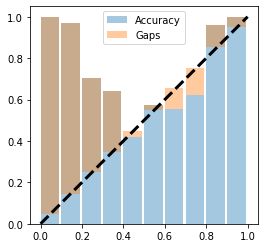

In [19]:
def p(res):
    plt.gca().set_aspect("equal")
    plt.bar(
        np.linspace(0, 1, nbins + 1)[:-1],
        res["accuracies"],
        width=1.0 / (nbins) - 0.01,
        align="edge",
        label="Accuracy",
        alpha=0.4,
    )
    gaps = res["accuracies"] - res["confidences"]

    plt.bar(
        np.linspace(0, 1, nbins + 1)[:-1],
        gaps,
        width=1.0 / (nbins) - 0.01,
        align="edge",
        label="Gaps",
        alpha=0.4,
        bottom=res["confidences"],
    )


    plt.plot(
        np.linspace(0, 1, nbins + 1), np.linspace(0, 1, nbins + 1), color="k", ls="--", lw=3
    )
    plt.legend()
p(res["Uncalibrated"])

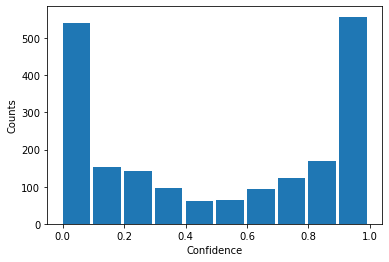

In [20]:
def p2(res):
    plt.bar(
    np.linspace(0, 1, nbins + 1)[:-1],
    res["counts"],
    width=1.0 / (nbins) - 0.01,
    align="edge",
    )
    # plt.plot(np.linspace(0, 1, nbins+1), np.linspace(0, 1, nbins+1), color='k', ls = '--', lw = 3)
    plt.xlabel("Confidence")
    plt.ylabel("Counts")
p2(res["Uncalibrated"])

In [21]:
gaps = res["Uncalibrated"]["accuracies"] - res["Uncalibrated"]["confidences"]
abs_gaps = np.abs(gaps)
weighted_abs_gaps = (res["Uncalibrated"]["counts"]/res["Uncalibrated"]["counts"].sum())*abs_gaps
ece = weighted_abs_gaps.sum()

print(ece, res["Uncalibrated"]['expected_calibration_error'])

0.4030961727328971 0.40309617273289716


### Platt Scaling

We will try to fit the following model using Logistic regression:

$$\mathbb{P}(\hat{Y}=Y \mid \hat{P}=p)=p$$

In [22]:
# Separate model for calibration
lr_calibration = LogisticRegression()

# Get the predictions on calibration set from our classification model
y_conf_calibration_set = lr.predict_proba(X_cal)[:, 1]

# Fit the calibration model on calibration dataset
lr_calibration.fit(y_conf_calibration_set.reshape(-1, 1), y_cal)

LogisticRegression()

In [23]:
# Transform the test probabilities via the calibration model 
cal_confidences_test = lr_calibration.predict_proba(y_conf.reshape(-1, 1))[:, 1]

In [24]:
nbins = 10
res["Platt_Own"] = compute_calibration(y_true, y_pred, cal_confidences_test, num_bins=nbins)
res['Platt_Own']["brier"] = brier_score_loss(y_true, cal_confidences_test)
res['Platt_Own']

{'accuracies': array([1.        , 0.72392638, 0.64634146, 0.55102041, 0.37142857,
        0.575     , 0.52380952, 0.57647059, 0.69325153, 1.        ]),
 'confidences': array([0.05224118, 0.14617929, 0.24288649, 0.3438167 , 0.44552489,
        0.55763552, 0.64909155, 0.75804804, 0.8576268 , 0.94709818]),
 'counts': array([664, 163,  82,  49,  35,  40,  42,  85, 163, 677]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8795,
 'avg_confidence': 0.5029262176130223,
 'expected_calibration_error': 0.4266562500551195,
 'max_calibration_error': 0.9477588171758138,
 'brier': 0.08140921827092136}

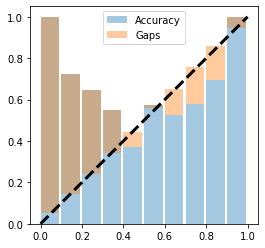

In [25]:
p(res["Platt_Own"])

In [26]:
keys = ['avg_accuracy', 'avg_confidence','expected_calibration_error', 'max_calibration_error'] #, brier]


In [27]:
def summarise_results(res):
    out = {}
    for method in res.keys():
        temp = {k: res[method][k] for k in keys}
        out[method] = temp
    return pd.DataFrame(out)

In [28]:
summarise_results(res)

,Uncalibrated,Platt_Own
avg_accuracy,0.879500,0.879500
avg_confidence,0.504004,0.502926
expected_calibration_error,0.403096,0.426656
max_calibration_error,0.952077,0.947759


In [29]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(lr, cv='prefit')
calibrator.fit(X_cal, y_cal)
yhat = calibrator.predict(X_test)

In [30]:
cal_conf_sk = calibrator.predict_proba(X_test)[:, 1]

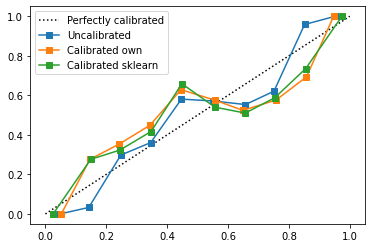

In [31]:
from sklearn.calibration import calibration_curve
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
frac_of_pos, mean_pred_value = calibration_curve(y_test, y_conf, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Uncalibrated")

frac_of_pos, mean_pred_value = calibration_curve(y_test, cal_confidences_test, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Calibrated own")

frac_of_pos, mean_pred_value = calibration_curve(y_test, cal_conf_sk, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Calibrated sklearn")
plt.legend()

In [32]:
res['Platt_Sklearn'] = compute_calibration(y_true, y_pred, cal_conf_sk, num_bins=nbins)
res['Platt_Sklearn']["brier"] = brier_score_loss(y_true, cal_conf_sk)


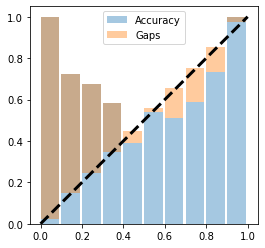

In [33]:
p(res['Platt_Sklearn'])

In [34]:
summarise_results(res)

,Uncalibrated,Platt_Own,Platt_Sklearn
avg_accuracy,0.879500,0.879500,0.879500
avg_confidence,0.504004,0.502926,0.502318
expected_calibration_error,0.403096,0.426656,0.419989
max_calibration_error,0.952077,0.947759,0.974662


### Isotonic Regression

In [35]:
from sklearn.isotonic import IsotonicRegression

model=IsotonicRegression()
model.fit(y_conf_calibration_set.reshape(-1, 1), y_cal)
cal_confidences_test_isotonic = model.predict(y_conf.reshape(-1, 1))

In [36]:
np.isnan(cal_confidences_test_isotonic).sum()

5

In [37]:
res['Isotonic_Own'] = compute_calibration(y_true, y_pred, cal_confidences_test_isotonic, num_bins=nbins)
#res['Isotonic_Own']["brier"] = brier_score_loss(y_true, cal_confidences_test_isotonic)

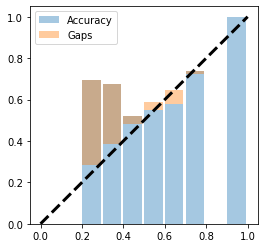

In [38]:
p(res['Isotonic_Own'])

In [39]:
summarise_results(res)

,Uncalibrated,Platt_Own,Platt_Sklearn,Isotonic_Own
avg_accuracy,0.879500,0.879500,0.879500,0.817562
avg_confidence,0.504004,0.502926,0.502318,0.759125
expected_calibration_error,0.403096,0.426656,0.419989,0.072767
max_calibration_error,0.952077,0.947759,0.974662,0.412395


In [40]:
calibrator = CalibratedClassifierCV(lr, cv='prefit', method='isotonic')
calibrator.fit(X_cal, y_cal)
yhat = calibrator.predict(X_test)
cal_conf_sk_isotonic = calibrator.predict_proba(X_test)[:, 1]

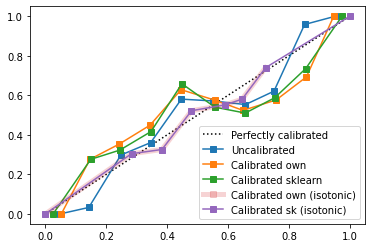

In [41]:
from sklearn.calibration import calibration_curve
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
frac_of_pos, mean_pred_value = calibration_curve(y_test, y_conf, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Uncalibrated")

frac_of_pos, mean_pred_value = calibration_curve(y_test, cal_confidences_test, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Calibrated own")

frac_of_pos, mean_pred_value = calibration_curve(y_test, cal_conf_sk, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Calibrated sklearn")


frac_of_pos, mean_pred_value = calibration_curve(y_test, cal_confidences_test_isotonic, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Calibrated own (isotonic)", lw=5, alpha=0.2)


frac_of_pos, mean_pred_value = calibration_curve(y_test, cal_conf_sk_isotonic, n_bins=10)
plt.plot(mean_pred_value, frac_of_pos, "s-", label="Calibrated sk (isotonic)")
plt.legend()

In [42]:
res['Isotonic_sklearn'] = compute_calibration(y_true, y_pred, cal_conf_sk_isotonic, num_bins=nbins)

In [43]:
summarise_results(res)

,Uncalibrated,Platt_Own,Platt_Sklearn,Isotonic_Own,Isotonic_sklearn
avg_accuracy,0.879500,0.879500,0.879500,0.817562,0.817976
avg_confidence,0.504004,0.502926,0.502318,0.759125,0.759671
expected_calibration_error,0.403096,0.426656,0.419989,0.072767,0.072602
max_calibration_error,0.952077,0.947759,0.974662,0.412395,0.412395
